In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import svm

In [2]:
# Chargement et normalisation des données
df = pd.read_pickle('data/data.pkl')
data = df[['h2s', 'pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']]
df[['h2s', 'pressure', 'temperature', 'humidity', 'so2', 'h2s_ref']] =  data.apply(pd.to_numeric, errors="coerce").apply(lambda x: (x - np.mean(x)) / (np.std(x)))
print(len(df))
df = df[pd.notnull(df).all(axis=1)] # On ne garde que les données sans NaN etc..
print(len(df))
df.head()

19445
8676


,date,h2s,pressure,temperature,humidity,n_points,so2,h2s_ref,captor
4,2016-05-23 09:15:00,1.673433,0.047316,0.996046,-1.610853,15,-0.259294,-0.709240,1303
9,2016-05-23 10:30:00,1.530588,0.202130,0.996046,-1.677224,15,-0.259294,-0.709240,1303
20,2016-05-23 13:15:00,1.637722,0.356944,0.996046,-1.809965,15,-0.259294,-0.709240,1303
25,2016-05-23 14:30:00,1.655577,0.356944,0.996046,-1.809965,15,-0.259294,-0.561424,1303
31,2016-05-23 16:00:00,1.566299,0.356944,0.996046,-1.876336,15,-0.259294,-0.709240,1303


In [3]:
# Permutation et séparation en jeux de données d'apprentissage
#df = df.reindex(np.random.permutation(df.index))
df.head()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    print(nb_rows, len(dataframe))
    return dataframe[:nb_rows], dataframe[nb_rows:]

df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

def dataframe_to_xy(df):
    return np.array(df[['h2s', 'pressure', 'temperature', 'humidity', 'so2']]), np.array(df['h2s_ref'])

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)


clf = svm.SVR()
clf.fit(X_train, y_train) 
clf.score(X_train, y_train)
clf.get_params()

4338 8676
2169 4338


{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [4]:
C_grid = np.logspace(-2, 3, 10)
gamma_grid = np.logspace(-5, 2, 10)

scores = np.empty((len(C_grid), len(gamma_grid)))
for i in range(len(C_grid)):
    for j in range(len(gamma_grid)):
        clf = svm.SVR(C=C_grid[i], gamma=gamma_grid[j], verbose=0)
        clf.fit(X_train, y_train)
        score = clf.score(X_valid, y_valid)
        scores[i, j] = score

In [5]:
C_idx, gamma_idx = np.unravel_index(scores.argmax(), scores.shape) # Meilleur résultat en validation
clf = svm.SVR(C=C_grid[C_idx], gamma=gamma_grid[gamma_idx])
clf.fit(X_train, y_train) 
err_valid = clf.score(X_valid, y_valid)
err_test = clf.score(X_test, y_test)

print(err_valid, err_test)

-0.270136190461 -0.106050542672


In [11]:
predictions = clf.predict(X_test)
tolerances = np.linspace(0, 1, 10)
acc = []
for tol in tolerances:
    acc.append(np.sum(np.abs(predictions.flatten() - y_test.flatten()) <= tol) / len(predictions))

#min_predictions = np.array(pd.DataFrame(y_test).apply(lambda x: (x - x*tol)))
#max_predictions = np.array(pd.DataFrame(y_test).apply(lambda x: (x + x*tol)))
print(acc)

[0.0, 0.15629322268326418, 0.23651452282157676, 0.28169663439372983, 0.47533425541724295, 0.56984785615491007, 0.71692023974181651, 0.72614107883817425, 0.77224527431996315, 0.85892116182572609]


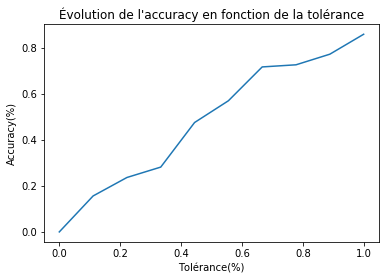

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.enable_notebook()


plt.plot(tolerances, acc)
plt.title("Évolution de l'accuracy en fonction de la tolérance")
plt.xlabel("Tolérance(%)")
plt.ylabel("Accuracy(%)")
plt.show()

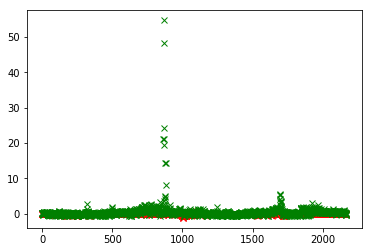

In [10]:
plt.plot(predictions, 'rx')
plt.plot(y_test, 'gx')
plt.show()

In [1]:
acc

NameError: name 'acc' is not defined